# First Look at Exchange Rates

### week 3-1

In this note, we do some exploratory data analysis with KRW/USD exchange rate data. Some topics discussed here include:

* Setting appropriate intervals for obtaining data
* Setting appropriate data points for obtaining data
* Visualizing exchange rates in a plot and histogram
* An example of misleading forecasting


> *Note 1. source code, exmaples and data: KAIST Business school, Prof. Jaehoon Lee*\
> *Note 2. The concpets covered here (e.g., real XR, market XR, absolute PPP) are from second to third year undergraduate finance course, so concepts themselves are not explained in details here.*

In [1]:
import pandas as pd

#### **Importing and preprocessing data**

In [2]:
#data file is provided in a separate folder in this repository
df_xr = pd.read_excel('data/krw_usd_xr.xlsx')

In [3]:
#brief look at the data
#the data can be obtained using Bank of Korea API system
df_xr.head(3)

,date,KRW/USD
0,1964-05-04,255.77
1,1964-05-05,255.77
2,1964-05-06,255.77


In [4]:
#note that 'date' column is already in datatime data type. Meaning it is already timestamped.
##df_xr['date'] = df_xr.to_datetime(df_xr['date']) -> not required
df_xr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16989 entries, 0 to 16988
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   date     16989 non-null  datetime64[ns]
 1   KRW/USD  16989 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 265.6 KB


In [5]:
#date-indexing
df_xr = df_xr.set_index('date')

#### **Visualization and finding the right interval**

In [6]:
import matplotlib.pyplot as plt

In [7]:
plt.rcParams['figure.figsize'] = (10, 4)

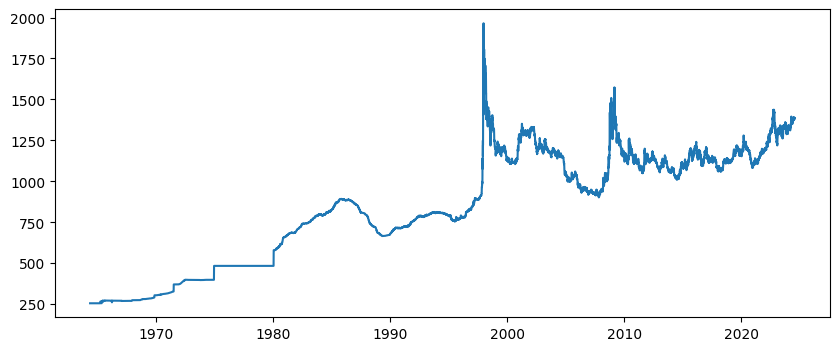

In [8]:
plt.plot(df_xr['KRW/USD'])
plt.show()

> Until somewhere around early 80's, the exchange rate shows unusual pattern.\
> For someone familiar with South Korean monetary regime would know this is because of the fixed rate regime in place in contrast to nowdays.\
> Let's take a closer look to see exactly when the regime changed.

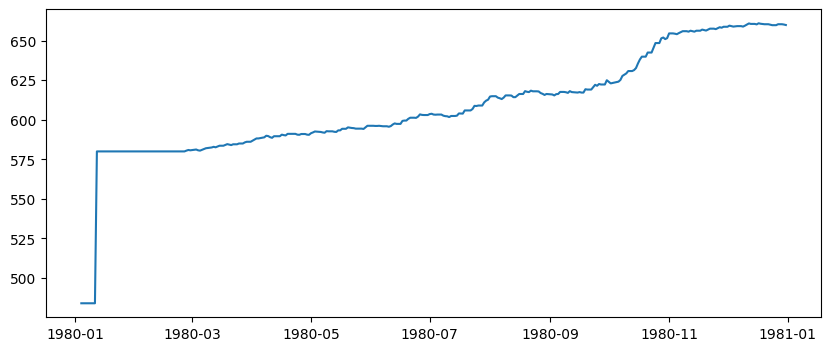

In [9]:
#closer look in 1980
plt.plot(df_xr.loc['1980-01-01' : '1980-12-31']['KRW/USD'])

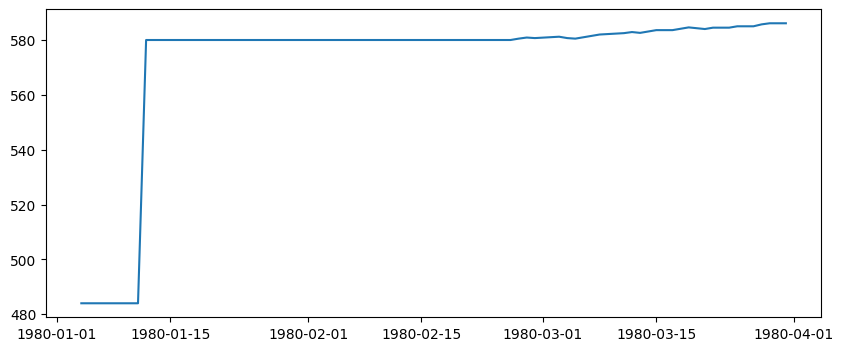

In [10]:
#even more closer look in within the year 1980
plt.plot(df_xr.loc['1980-01-01' : '1980-03-31']['KRW/USD'])

> For more consistent forecasting, discard data from fixed-rate regime.

In [11]:
#discard data before 1980-03-01
df_xr = df_xr.loc['1980-03-01':]

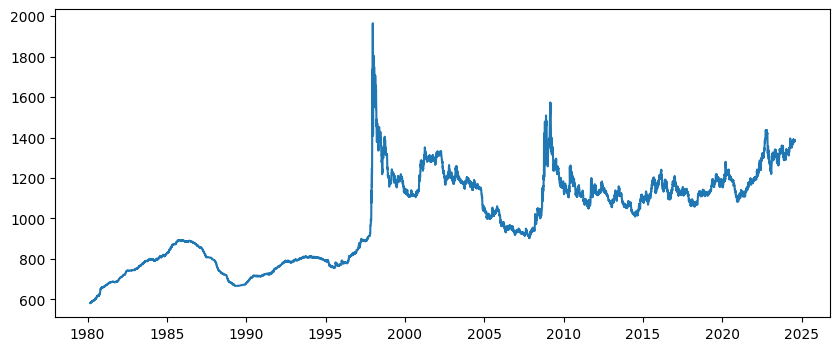

In [14]:
#only floating rate regime is of our interest
plt.plot(df_xr['KRW/USD'])
plt.show()

#### **Convert to monthly observations**

daily observations mean too many data points -> convert them to monthly dataset

##### (1) Monthly average - old and hard way

In [15]:
df_xr

,KRW/USD
date,
1980-03-03,581.2
1980-03-04,580.7
1980-03-05,580.5
1980-03-06,581.0
1980-03-07,581.5
...,...
2024-07-23,1388.6
2024-07-24,1385.1
2024-07-25,1385.1


In [16]:
df_xr['ym'] = df_xr.index.year * 100 + df_xr.index.month

In [17]:
df_xr.groupby('ym')['KRW/USD'].mean()

ym
198003     583.504167
198004     589.808000
198005     593.600000
198006     598.945833
198007     605.400000
             ...     
202403    1330.695000
202404    1367.828571
202405    1365.390000
202406    1380.131579
202407    1383.390476
Name: KRW/USD, Length: 533, dtype: float64

In [19]:
del df_xr['ym']

In [20]:
df_xr.head(3)

,KRW/USD
date,
1980-03-03,581.2
1980-03-04,580.7
1980-03-05,580.5


##### (2) Monthly average - easy and hard way

In [21]:
df_xr.resample('ME').mean()

,KRW/USD
date,
1980-03-31,583.504167
1980-04-30,589.808000
1980-05-31,593.600000
1980-06-30,598.945833
1980-07-31,605.400000
...,...
2024-03-31,1330.695000
2024-04-30,1367.828571
2024-05-31,1365.390000


> Note 1. 'ME' means monthly. For quarterly average, go for 'QE'.\
> Note 2. date is the end date of the month: because monthly average is only realized at the end of a month. 

##### (3) End-of-month observation

high liquidity assets (e.g., currency) -> use end-of-month observation (due to timeliness of data)\
low liquidity assets (e.g., penny stocks) -> use monthly average (due to noises)

In [22]:
df_monthly = df_xr.resample('ME').last()

In [23]:
df_monthly.head(3)

,KRW/USD
date,
1980-03-31,586.1
1980-04-30,590.5
1980-05-31,596.2


In [24]:
df_monthly.tail(3)

,KRW/USD
date,
2024-05-31,1376.5
2024-06-30,1389.2
2024-07-31,1385.4


#### **Wrong prediction case: use raw price data as is**

In [26]:
import statsmodels.api as sm

In [27]:
X = df_monthly.iloc[: -1]

In [28]:
X = sm.add_constant(X)

In [29]:
Y = df_monthly.iloc[1 :]

In [30]:
model = sm.OLS(Y, X.values)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                KRW/USD   R-squared:                       0.973
Model:                            OLS   Adj. R-squared:                  0.973
Method:                 Least Squares   F-statistic:                 1.903e+04
Date:                Tue, 06 Aug 2024   Prob (F-statistic):               0.00
Time:                        18:38:52   Log-Likelihood:                -2653.1
No. Observations:                 532   AIC:                             5310.
Df Residuals:                     530   BIC:                             5319.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         15.8438      7.343      2.158      0.031       1.419      30.268
x1             0.9857      0.007    137.965      0.000       0.972       1.000
==============================================================================
Omnibus:                      165.434   Durbin-Watson:                   1.798
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6511.396
Skew:                           0.593   Prob(JB):                         0.00
Kurtosis:                      20.098   Cond. No.                     4.90e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.9e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### **Correct way to predict exchange rates: use return**

##### Method 1. shift

In [31]:
df_monthly['lagged'] = df_monthly['KRW/USD'].shift(1)

In [32]:
df_monthly.head(10)

,KRW/USD,lagged
date,,
1980-03-31,586.1,NaN
1980-04-30,590.5,586.1
1980-05-31,596.2,590.5
1980-06-30,603.0,596.2
1980-07-31,612.7,603.0
1980-08-31,616.3,612.7
1980-09-30,625.0,616.3
1980-10-31,651.6,625.0
1980-11-30,658.8,651.6


In [33]:
df_monthly['ret1'] = (df_monthly['KRW/USD'] / df_monthly['lagged'] - 1) * 100

In [34]:
df_monthly.head(3)

,KRW/USD,lagged,ret1
date,,,
1980-03-31,586.1,NaN,NaN
1980-04-30,590.5,586.1,0.750725
1980-05-31,596.2,590.5,0.965284


##### Method 2. pct_change

In [35]:
df_monthly['ret2'] = df_monthly['KRW/USD'].pct_change() * 100

In [36]:
df_monthly.head(3)

,KRW/USD,lagged,ret1,ret2
date,,,,
1980-03-31,586.1,NaN,NaN,NaN
1980-04-30,590.5,586.1,0.750725,0.750725
1980-05-31,596.2,590.5,0.965284,0.965284


##### Summary Statistic

In [37]:
df_monthly['ret2'].describe()

count    532.000000
mean       0.202840
std        2.897403
min      -15.931955
25%       -0.832552
50%        0.077968
75%        0.928488
max       21.601650
Name: ret2, dtype: float64

In [39]:
summary = df_monthly['ret2'].describe()

In [40]:
norm_min = (summary['min'] - summary['mean']) / summary['std']
norm_max = (summary['max'] - summary['mean']) / summary['std']

print("Normalized Range: {:.2f} ~ {:.2f}".format(norm_min, norm_max))

Normalized Range: -5.57 ~ 7.39


> The normalized range suggests that it is hardly a normal distribution (e.g., 5 sigma distance, 7 sigma distance)\
> The histogram below also suggests the same conclusion

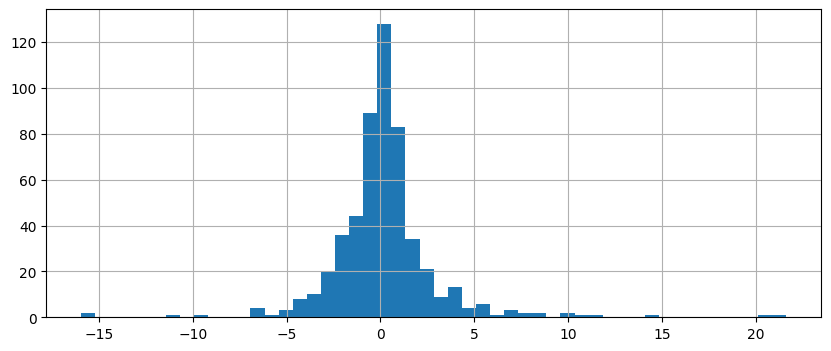

In [41]:
df_monthly['ret2'].hist(bins = 50)
plt.show()

##### **Predicting exchange rate**

In [42]:
df_monthly = df_monthly.dropna()

In [43]:
X = df_monthly.iloc[:-1]['ret2']
X = sm.add_constant(X)

In [44]:
Y = df_monthly.iloc[1:]['ret2']

In [45]:
model = sm.OLS(Y, X.values)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   ret2   R-squared:                       0.027
Model:                            OLS   Adj. R-squared:                  0.025
Method:                 Least Squares   F-statistic:                     14.44
Date:                Tue, 06 Aug 2024   Prob (F-statistic):           0.000161
Time:                        18:46:10   Log-Likelihood:                -1311.2
No. Observations:                 531   AIC:                             2626.
Df Residuals:                     529   BIC:                             2635.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1686      0.125      1.353      0.177      -0.076       0.413
x1             0.1630      0.043      3.800      0.000       0.079       0.247
==============================================================================
Omnibus:                      156.195   Durbin-Watson:                   1.996
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4045.568
Skew:                           0.660   Prob(JB):                         0.00
Kurtosis:                      16.458   Cond. No.                         2.91
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

> Now you can see the R-squared has plummeted to around 2.7% here.\
> Yet, the p-value of the coefficient is almost zero, which indicates there is still some linear relationship going on between previous day's change rate to today's change rate.\
> However, even above results are misleading. We will see why below. 

### **The impact of IMF incident**

South Korea suffered financial crisis and recieved IMF bailout package during the late 1990's.\
This is a watershed moment for South Korea; experts often argue that South Korean economy became something totally different in every aspects from what it was before the crisis.\
The impact of IMF bailout and the currency crisis had a huge impact on its forieng exchange rate policy; South Korea had a tight control over its exchange rate but after the crisis it opened up its currency market completely, let Korean Won fluctuate freely.\
So not only 80's when South Korea had fixed currency rate regime, but also 90's data should be discarded.

We will show that autocorrelation was only visible until 90's and the currency rate follows largely randomwalk process afterwards.

In [46]:
df_post_imf = df_monthly.loc['1999-01-01':]

In [47]:
X = df_post_imf.iloc[:-1]['ret2']
X = sm.add_constant(X)

In [48]:
Y = df_post_imf.iloc[1:]['ret2']

In [49]:
model = sm.OLS(Y, X.values)
results = model.fit()
results.summary()

#p-value is not significant
#momentum only exists prior 1997 crisis

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   ret2   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.8212
Date:                Tue, 06 Aug 2024   Prob (F-statistic):              0.366
Time:                        18:55:37   Log-Likelihood:                -766.89
No. Observations:                 306   AIC:                             1538.
Df Residuals:                     304   BIC:                             1545.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1022      0.170      0.601      0.549      -0.233       0.437
x1            -0.0518      0.057     -0.906      0.366      -0.164       0.061
==============================================================================
Omnibus:                       57.320   Durbin-Watson:                   1.989
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              315.895
Skew:                           0.607   Prob(JB):                     2.54e-69
Kurtosis:                       7.827   Cond. No.                         2.98
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

> Now, not only R-square is very low but also the coefficient is not significantly different from zero.\
> In the next courses, we see how to properly predict exchange rates in greater details.